개요

폐렴 진단기를 만들어보자

In [1]:
#패키지 임포트
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
#데이터 구조 체크
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
#train 데이터안 정상이미지,폐렴이미지 개수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [6]:
#작업시 미니배치 활용하기 위해 tf.data 인스턴스 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
#트레인데이터, 검증데이터 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
#train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
#이미지 리사이징, 라벨링 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [12]:
#테스트 데이터 만들고 개수 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [13]:
# #효율적인 학습 위해 데이터 변환
# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size) #셔플 섞는 범위 크기
#     ds = ds.repeat() #repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.
#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

In [14]:
# # 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(10,10))
#     for n in range(BATCH_SIZE):
#         ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
#         plt.imshow(image_batch[n])
#         if label_batch[n]:
#             plt.title("PNEUMONIA")
#         else:
#             plt.title("NORMAL")
#         plt.axis("off")


# image_batch, label_batch = next(iter(train_ds))
# show_batch(image_batch.numpy(), label_batch.numpy())

In [13]:
#콘볼루션 블록 생성
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),#정규화
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [14]:
#덴스 블록 생성
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),#정규화
        tf.keras.layers.Dropout(dropout_rate)#드랍아웃
    ])
    
    return block

In [15]:
#모델 생성
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [16]:
#데이버 불균형 보완 위해 가중치 설정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [17]:
#컴파일
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
#모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 68s 210ms/step - loss: 0.3617 - accuracy: 0.8261 - precision: 0.9560 - recall: 0.8033 - val_loss: 0.8996 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 206ms/step - loss: 0.2277 - accuracy: 0.9136 - precision: 0.9719 - recall: 0.9104 - val_loss: 1.5459 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 206ms/step - loss: 0.2284 - accuracy: 0.9143 - precision: 0.9728 - recall: 0.9102 - val_loss: 0.9891 - val_accuracy: 0.7346 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 55s 210ms/step - loss: 0.1793 - accuracy: 0.9267 - precision: 0.9788 - recall: 0.9215 - val_loss: 0.0961 - val_accuracy: 0.9673 - val_precision: 0.9643 - val_recall: 0.9921
Epoch 5/10
261/261 [==============================] - 55s 213ms/step - loss: 0.1935 - accura

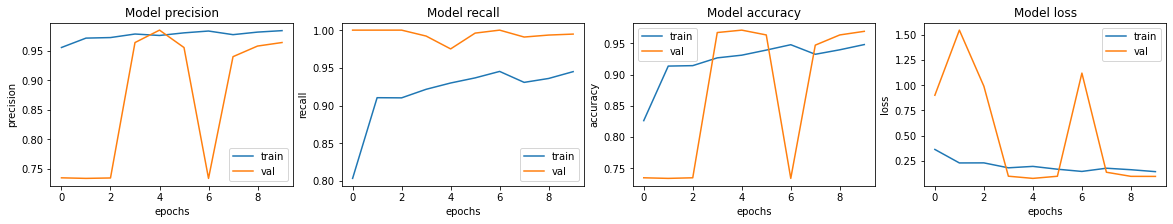

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
#테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 123ms/step - loss: 0.9131 - accuracy: 0.7724 - precision: 0.7348 - recall: 0.9949
Loss: 0.9131187796592712,
Accuracy: 0.7724359035491943,
Precision: 0.7348484992980957,
Recall: 0.9948717951774597


In [18]:
#데이터 증강
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [19]:
for image, label in train_ds.take(1):
    print(f"Image shape: {image.shape}")

Image shape: (16, 180, 180, 3)


In [23]:
#레즈넷 모델 구축
import tensorflow as tf

# ResNet 스타일의 Residual 블록을 구현하는 함수
def res_block(input_tensor, filters, stride=1):
    x = tf.keras.layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if stride != 1 or input_tensor.shape[-1] != filters:
        input_tensor = tf.keras.layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(input_tensor)

    x = tf.keras.layers.add([x, input_tensor])
    x = tf.keras.layers.ReLU()(x)
    return x

def build_model():
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # ResNet 스타일의 첫 번째 conv1 블록과 max pooling 추가
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual Block Layers
    x = res_block(x, 64)
    x = res_block(x, 64)

    x = res_block(x, 128, stride=2)
    x = res_block(x, 128)

    x = res_block(x, 256, stride=2)
    x = res_block(x, 256)

    x = res_block(x, 512, stride=2)
    x = res_block(x, 512)

    # 전역 평균 풀링
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Dropout과 Dense 레이어 추가 (사용자 요구 사항 반영)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    # 최종 출력층 (시그모이드)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # 모델 정의
    model = tf.keras.Model(inputs, outputs)
    return model

# 모델 생성
model = build_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 90, 90, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 90, 90, 64)   256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 45, 45, 64)   0           batch_normalization_7[0][0]      
______________________________________________________________________________________________

In [24]:
#레즈넷 모델 컴파일
#컴파일
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
#레즈넷 모델 학습
#모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 68s 205ms/step - loss: 0.3866 - accuracy: 0.8405 - precision: 0.9485 - recall: 0.8307 - val_loss: 2.5585 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 204ms/step - loss: 0.2468 - accuracy: 0.9004 - precision: 0.9746 - recall: 0.8894 - val_loss: 0.6363 - val_accuracy: 0.7760 - val_precision: 0.7656 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 206ms/step - loss: 0.2427 - accuracy: 0.9068 - precision: 0.9762 - recall: 0.8967 - val_loss: 0.1366 - val_accuracy: 0.9510 - val_precision: 0.9697 - val_recall: 0.9633
Epoch 4/10
261/261 [==============================] - 54s 208ms/step - loss: 0.1906 - accuracy: 0.9169 - precision: 0.9828 - recall: 0.9041 - val_loss: 0.8582 - val_accuracy: 0.8115 - val_precision: 0.7954 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 55s 212ms/step - loss: 0.1665 - accura

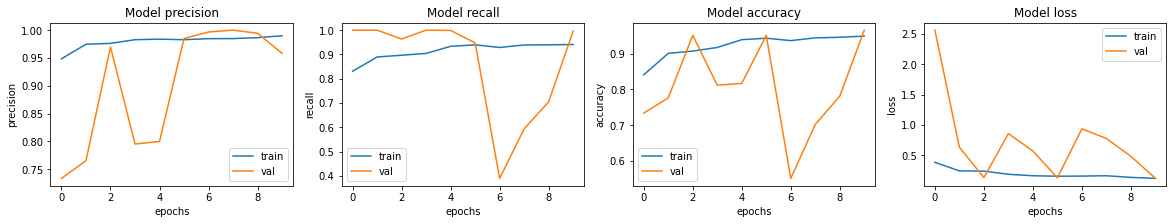

In [27]:
#레즈넷 모델 학습 지표
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
#테스트 데이터로 레즈넷 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 123ms/step - loss: 1.9782 - accuracy: 0.7019 - precision: 0.6771 - recall: 1.0000
Loss: 1.978187918663025,
Accuracy: 0.7019230723381042,
Precision: 0.6770833134651184,
Recall: 1.0


In [20]:
#조금 더 간단하게 수정한 레즈넷 모델

import tensorflow as tf

# 단순화된 Residual 블록 함수
def res_block(input_tensor, filters, stride=1):
    x = tf.keras.layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # 입력과 크기가 다를 경우 스킵 연결을 위한 차원 맞춤
    if stride != 1 or input_tensor.shape[-1] != filters:
        input_tensor = tf.keras.layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(input_tensor)

    # 스킵 연결
    x = tf.keras.layers.add([x, input_tensor])
    x = tf.keras.layers.ReLU()(x)
    return x

def build_model():
    inputs = tf.keras.Input(shape=(180, 180, 3))  # IMAGE_SIZE를 180으로 고정

    # 첫 번째 Conv 블록과 Max Pooling
    x = tf.keras.layers.Conv2D(32, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # 단순화된 Residual Block Layers
    x = res_block(x, 32)
    x = res_block(x, 32)

    x = res_block(x, 64, stride=2)
    x = res_block(x, 64)

    x = res_block(x, 128, stride=2)
    x = res_block(x, 128)

    x = res_block(x, 256, stride=2)
    x = res_block(x, 256)

    # 전역 평균 풀링
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Dropout과 Dense 레이어 (단순화된 버전)
    x = tf.keras.layers.Dropout(0.4)(x)  # 드롭아웃 비율 줄임
    x = tf.keras.layers.Dense(256, activation='relu')(x)  # Dense 크기 줄임
    x = tf.keras.layers.Dropout(0.3)(x)  # 드롭아웃 비율 줄임
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    # 최종 출력층 (시그모이드)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # 모델 정의
    model = tf.keras.Model(inputs, outputs)
    return model

# 모델 생성
model = build_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 90, 90, 32)   4736        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 90, 90, 32)   128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 45, 45, 32)   0           batch_normalization_7[0][0]      
______________________________________________________________________________________________

In [21]:
#간단하게 수정한 레즈넷모델 컴파일
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
#간단하게 수정한 레즈넷 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 68s 205ms/step - loss: 0.3018 - accuracy: 0.8767 - precision: 0.9619 - recall: 0.8687 - val_loss: 0.4172 - val_accuracy: 0.8298 - val_precision: 0.8239 - val_recall: 0.9764
Epoch 2/10
261/261 [==============================] - 53s 203ms/step - loss: 0.1891 - accuracy: 0.9267 - precision: 0.9791 - recall: 0.9212 - val_loss: 0.5946 - val_accuracy: 0.6519 - val_precision: 0.9902 - val_recall: 0.5308
Epoch 3/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1567 - accuracy: 0.9341 - precision: 0.9816 - recall: 0.9289 - val_loss: 1.3245 - val_accuracy: 0.4644 - val_precision: 1.0000 - val_recall: 0.2709
Epoch 4/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1756 - accuracy: 0.9346 - precision: 0.9759 - recall: 0.9354 - val_loss: 0.2382 - val_accuracy: 0.9183 - val_precision: 0.9033 - val_recall: 0.9947
Epoch 5/10
261/261 [==============================] - 55s 211ms/step - loss: 0.1473 - accura

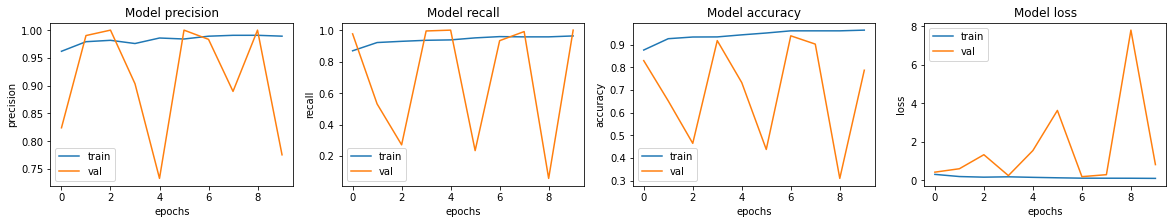

In [23]:
#간단하게 수정한 레즈넷 모델 학습 지표
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
#테스트 데이터로 간단하게 수정한 레즈넷 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 112ms/step - loss: 3.7410 - accuracy: 0.6330 - precision: 0.6300 - recall: 1.0000
Loss: 3.740983247756958,
Accuracy: 0.6330128312110901,
Precision: 0.6300484538078308,
Recall: 1.0


회고

베이스 모델은 정확도 77%, 정밀도 73%, 재현율 99%였다.

레즈넷 모델에 이미지 좌우변환정도의 간단한 데이터 증강을 해서 돌렸을땐 더 낮은 지표인 정확도 70% 정밀도 67%가 나왔다.

조금 더 간단하게 수정한 레즈넷 모델(간단한 데이터 증강 그대로 사용)은 더 더 낮은 지표인 정확도 63% 정밀도 63%가 나왔다.

베이스 모델에 데이터 증강만 적용한 경우도 테스트 해보고 싶었는데 작업하다 튕기는 경우가 많아서 해보지 못했다.